In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mu = 1
sigma = 2
learning_rate = 1e-1
epsilon = 0
num_epochs = 3
TEST_SIZE = 100
TRAIN_SIZE = 30
BEST_MODEL_PATH = 'best_gaussian_mixture_linear_loss_model.pt'

In [53]:
class WeightClipper(object):
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            W = 2.
            module.weight.data = w.clamp(-W, W)

clipper = WeightClipper()

In [54]:
x_test = torch.unsqueeze(torch.cat([torch.distributions.Normal(-mu, sigma).sample((TEST_SIZE,)), torch.distributions.Normal(mu, sigma).sample((TEST_SIZE,))]), dim=1).float()
y_test = torch.unsqueeze(torch.cat([-torch.ones(TEST_SIZE), torch.ones(TEST_SIZE)]), dim=1).float()
test_set = Data.TensorDataset(x_test, y_test)
test_loader = Data.DataLoader(dataset=test_set, batch_size=TEST_SIZE//10, shuffle=False)

In [55]:
def linear_loss(output, target):
    return -output.t() @ target

In [56]:
def fgsm(model, x, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    x.requires_grad = True
    output = model(x)
    loss = loss_fn(output, y)
    model.zero_grad()
    loss.backward()
    return epsilon * x.grad.data.sign()

In [57]:
def fit(num_epochs, train_loader, model, loss_fn, opt):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0
        best_loss = float('inf')
        
        for x, y in train_loader:
            opt.zero_grad()
            delta = fgsm(model, x, y, epsilon)
            # perturbed training data
            x_pert = x + delta
            # predicted output
            y_pred = model(x_pert)
            loss = loss_fn(y_pred, y)
            loss.backward()
            opt.step()
            model.apply(clipper)
            sum_loss += float(loss)
        epoch_train_loss = sum_loss / train_size
        if epoch_train_loss < best_loss:
            best_loss = epoch_train_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

    sum_test_loss = 0
    model = nn.Linear(1, 1, bias=False)
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    for x, y in test_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        sum_test_loss += loss
    temp = sum_test_loss / TEST_SIZE
    return temp

In [58]:
loss_fn = linear_loss
test_losses = np.zeros(TRAIN_SIZE)

for train_size in range(1, TRAIN_SIZE+1):
    N = 30
    temp = np.zeros(N)
    for i in range(N):
        model = nn.Linear(1, 1, bias=False)
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        batch_size = min(5, train_size)
        x_train = torch.unsqueeze(torch.cat([torch.distributions.Normal(-mu, sigma).sample((train_size,)), torch.distributions.Normal(mu, sigma).sample((train_size,))]), dim=1).float()
        y_train = torch.unsqueeze(torch.cat([-torch.ones(train_size), torch.ones(train_size)]), dim=1).float()
        train_set = Data.TensorDataset(x_train, y_train)
        train_loader = Data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        test_loss = fit(num_epochs, train_loader, model, loss_fn, opt)
        temp[i] = test_loss.item()
    mean = np.mean(temp)
    test_losses[train_size-1] = test_loss.item()

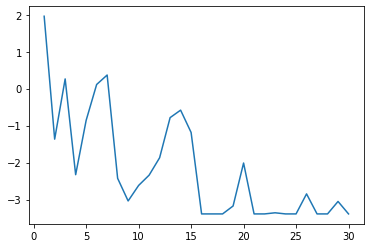

In [59]:
train_sizes = np.arange(1, TRAIN_SIZE+1)
plt.plot(train_sizes, test_losses)

In [60]:
print(list(model.parameters()))

[Parameter containing:
tensor([[2.]], requires_grad=True)]


In [61]:
test_losses

array([ 1.9584564 , -1.36667085,  0.26251793, -2.32841253, -0.85779303,
        0.11192636,  0.36775771, -2.42685461, -3.03901267, -2.61920023,
       -2.34098625, -1.87006831, -0.78442401, -0.58212972, -1.18594587,
       -3.38967752, -3.38967752, -3.38967752, -3.17543244, -2.01275516,
       -3.38967752, -3.38967752, -3.35931301, -3.38967752, -3.38967752,
       -2.84813666, -3.38967752, -3.38967752, -3.05247712, -3.38967752])